## Prepare the dataset

In [1]:
import pandas as pd

train_path = 'data/hate_train.csv'

base_df = pd.read_csv(train_path)
base_df.head()

,sentence,label
0,Dla mnie faworytem do tytułu będzie Cracovia. ...,0
1,@anonymized_account @anonymized_account Brawo ...,0
2,"@anonymized_account @anonymized_account Super,...",0
3,@anonymized_account @anonymized_account Musi. ...,0
4,"Odrzut natychmiastowy, kwaśna mina, mam problem",0


Clean sentences - actualy no cleaning works best :D

In [2]:
cleaned_df = base_df.copy()

Print example of cleaned sentences

In [4]:
cleaned_df['sentence'][0:5].to_list()

['Dla mnie faworytem do tytułu będzie Cracovia. Zobaczymy, czy typ się sprawdzi.',
 '@anonymized_account @anonymized_account Brawo ty Daria kibic ma być na dobre i złe',
 '@anonymized_account @anonymized_account Super, polski premier składa kwiaty na grobach kolaborantów. Ale doczekaliśmy czasów.',
 '@anonymized_account @anonymized_account Musi. Innej drogi nie mamy.',
 'Odrzut natychmiastowy, kwaśna mina, mam problem']

Train test split

In [5]:
from sklearn.model_selection import train_test_split
from datasets import Dataset

train_df, eval_df = train_test_split(
    cleaned_df,
    test_size=0.2,
    random_state=42,
    stratify=cleaned_df['label']
)

train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
eval_ds = Dataset.from_pandas(eval_df .reset_index(drop=True))

print(f"Train dataset size: {len(train_ds)}")
print(f"Eval dataset size: {len(eval_ds)}")

Train dataset size: 8032
Eval dataset size: 2009


## Prepare the model

Load the model

In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# model_name = "dkleczek/bert-base-polish-uncased-v1"
model_name = "allegro/herbert-large-cased"
# model_name="deepsense-ai/trelbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allegro/herbert-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# special_tokens_dict = {
#     "additional_special_tokens": ["[USER]", "[URL]"]
# }

# tokenizer.add_special_tokens(special_tokens_dict)
# model.resize_token_embeddings(len(tokenizer))

Tokenize the datasets

In [8]:
from transformers.data.data_collator import DataCollatorWithPadding

def tokenize_fn(row):
    return tokenizer(row['sentence'], truncation=True, max_length=128)


tokenized_train_ds = train_ds.map(tokenize_fn, batched=True)
tokenized_eval_ds = eval_ds.map(tokenize_fn, batched=True)

data_collator = DataCollatorWithPadding(tokenizer)

Map:   0%|          | 0/8032 [00:00<?, ? examples/s]

Map:   0%|          | 0/2009 [00:00<?, ? examples/s]

Perform the training

In [ ]:
import numpy as np
from evaluate import load
from sklearn.utils import compute_class_weight
import torch
import torch.nn.functional as F
from transformers.training_args import TrainingArguments
from transformers.trainer import Trainer


accuracy_metric = load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_metric.compute(predictions=preds, references=labels)

    acc0 = (preds[labels == 0] == 0).mean() if np.any(labels == 0) else float('nan')
    acc1 = (preds[labels == 1] == 1).mean() if np.any(labels == 1) else float('nan')

    acc["acc_0"] = acc0
    acc["acc_1"] = acc1
    acc["avg_acc"] = (acc0 + acc1) / 2

    return acc


labels = np.array(tokenized_train_ds["label"])
weights = compute_class_weight("balanced", classes=np.unique(labels), y=labels)
class_weights = torch.tensor(weights, dtype=torch.float)


def custom_loss_fn(raw_outputs, labels, num_items_in_batch=None):
    logits = raw_outputs.logits if hasattr(raw_outputs, "logits") else raw_outputs
    cw = class_weights.to(logits.device)
    cw = torch.tensor([0.5, 1.0]).to(logits.device)
    loss_fct = torch.nn.CrossEntropyLoss(weight=cw, label_smoothing=0.05)
    loss = loss_fct(logits.view(-1, logits.size(-1)), labels.view(-1))
    return loss

batch_size = 64

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="steps",
    warmup_steps=200,
    learning_rate=1e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    max_grad_norm=1.0,
    weight_decay=0.01,
    logging_steps=50,
    eval_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_eval_ds,
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_loss_func=custom_loss_fn,
    compute_metrics=compute_metrics
)

trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Acc 0,Acc 1,Avg Acc
50,0.632800,0.495032,0.915381,1.000000,0.000000,0.500000
100,0.456100,0.391562,0.927327,0.986406,0.288235,0.637320
150,0.374100,0.385690,0.924340,0.964111,0.494118,0.729114
200,0.363700,0.363920,0.908910,0.933660,0.641176,0.787418
250,0.351600,0.361332,0.928820,0.966830,0.517647,0.742238
300,0.303900,0.377715,0.929816,0.961392,0.588235,0.774814
350,0.292000,0.400018,0.910403,0.929309,0.705882,0.817596
400,0.274200,0.411959,0.925336,0.954867,0.605882,0.780375
450,0.252300,0.418278,0.919363,0.941816,0.676471,0.809143
500,0.260100,0.409480,0.929318,0.963567,0.558824,0.761195


KeyboardInterrupt: 

Train the model

## Evaluate

In [10]:
import numpy as np

pred_output = trainer.predict(tokenized_eval_ds)

logits = pred_output.predictions
y_pred = np.argmax(logits, axis=-1)
y_true = pred_output.label_ids

Print the classification report

In [11]:
from sklearn.metrics import classification_report

cr = classification_report(y_true, y_pred, target_names=["non-hate","hate"], digits=4)
print(cr)

              precision    recall  f1-score   support

    non-hate     0.9594    0.9630    0.9612      1839
        hate     0.5828    0.5588    0.5706       170

    accuracy                         0.9288      2009
   macro avg     0.7711    0.7609    0.7659      2009
weighted avg     0.9275    0.9288    0.9281      2009



Plot the confusion matrix

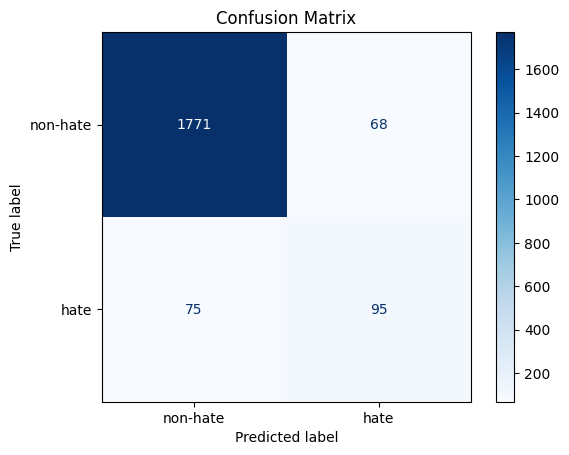

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["non-hate", "hate"])
disp.plot(ax=ax, cmap=plt.cm.Blues)
ax.set_title("Confusion Matrix")
plt.show()

Acc per threshold

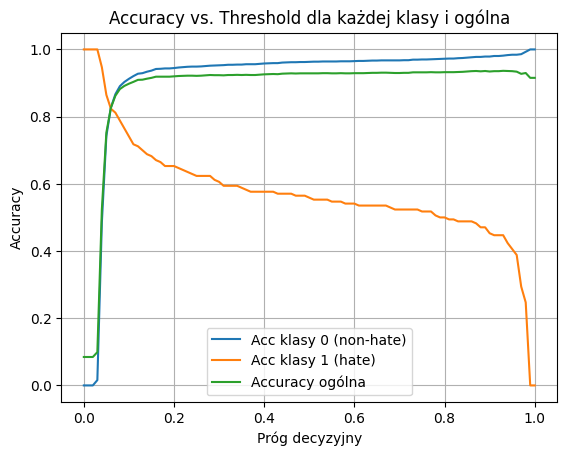

Najlepszy próg decyzyjny: 0.93
Najlepsza dokładność ogólna: 0.9362867098058736


In [13]:
logits_stable = logits - np.max(logits, axis=1, keepdims=True)
exp_logits = np.exp(logits_stable)
probs = exp_logits[:, 1] / exp_logits.sum(axis=1)
 
thresholds = np.linspace(0, 1, 101)
acc0_list = []
acc1_list = []
acc_overall = []

for thr in thresholds:
    preds_thr = (probs > thr).astype(int)

    mask0 = (y_true == 0)
    mask1 = (y_true == 1)

    acc0_list.append((preds_thr[mask0] == 0).mean())
    acc1_list.append((preds_thr[mask1] == 1).mean())
    acc_overall.append((preds_thr == y_true).mean())

plt.plot(thresholds, acc0_list,   label="Acc klasy 0 (non-hate)")
plt.plot(thresholds, acc1_list,   label="Acc klasy 1 (hate)")
plt.plot(thresholds, acc_overall, label="Accuracy ogólna")

plt.xlabel("Próg decyzyjny")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Threshold dla każdej klasy i ogólna")
plt.legend()
plt.grid(True)
plt.show()

print("Najlepszy próg decyzyjny:", thresholds[np.argmax(acc_overall)])
print("Najlepsza dokładność ogólna:", max(acc_overall))

Print examples of misclassified samples

In [14]:
count = 0
texts = eval_df['sentence'].tolist()

for text, true, pred in zip(texts, y_true, y_pred):
    if true != pred:
        count += 1
        print(f"Example {count}")
        print("Text:      ", text)
        print("Predicted: ", pred)
        print("True:      ", true)
        print("-" * 60)
        if count >= 10:
            break

Example 1
Text:       Jarkacz boi się o odbyt, nie chce iść do ciupy, zrobi wszystko, nasi rodacy jednak to kupią
Predicted:  1
True:       0
------------------------------------------------------------
Example 2
Text:       RT @anonymized_account @anonymized_account w politykę to sie bawi Pierwsza Prezes SN....nie zauważyła Pani????
Predicted:  0
True:       1
------------------------------------------------------------
Example 3
Text:       Żolnierz żolnierza w dupę nawet tego wyklętego, ja jebię, chory kraj
Predicted:  0
True:       1
------------------------------------------------------------
Example 4
Text:       @anonymized_account @anonymized_account lepiej napisać że dostali wpierdol.A nie, bo ludzie którzy dostali po ryju by się mogli głupio poczuć.
Predicted:  0
True:       1
------------------------------------------------------------
Example 5
Text:       @anonymized_account co ty ćpasz chłopie ?
Predicted:  1
True:       0
-------------------------------------------------

## Save the results

In [22]:
test_path = 'data/hate_test_data.txt'

with open(test_path, encoding='utf-8') as f:
    lines = [line.strip() for line in f if line.strip()]

test_df = pd.DataFrame(lines, columns=['sentence'])
test_df.head()

,sentence
0,"@anonymized_account Spoko, jak im Duda z Moraw..."
1,@anonymized_account @anonymized_account Ale on...
2,@anonymized_account No czy Prezes nie miał rac...
3,@anonymized_account @anonymized_account Przeci...
4,@anonymized_account @anonymized_account Owszem...


In [23]:
tokenized_test_ds = Dataset.from_pandas(test_df).map(tokenize_fn, batched=False)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [27]:
import numpy as np
import torch
from sklearn.metrics import accuracy_score, classification_report

pred_output = trainer.predict(tokenized_test_ds)
logits      = pred_output.predictions
y_true      = pred_output.label_ids

logits_stable = logits - logits.max(axis=1, keepdims=True)
exp_logits   = np.exp(logits_stable)
probs        = exp_logits[:,1] / exp_logits.sum(axis=1)

thr = 0.93

y_pred_thr = (probs > thr).astype(int)

output_dir = "pred.csv"

output_df = pd.DataFrame({"predicted": y_pred_thr})
output_df.to_csv(output_dir, index=False, header=False)